In [1]:
import sys
from pathlib import Path
import os
sys.path.append(os.path.join(Path.cwd().parent, 'src')) 
sys.path.append(os.path.join(Path.cwd().parent, 'src', 'util')) 
from util.api_call import load_api_vars

vo = load_api_vars()

## Data Processing

In [2]:
import pandas as pd
data = pd.read_excel("../data/d.xls")
abstract = data['Abstract']
title = data['Article Title']

combine = title.str.cat(abstract, sep=' ')
combine = combine.to_list()

In [6]:
batch_size = 50
embeddings = []
for i in range(0, len(combine), batch_size):
    embeddings += vo.embed(combine[i:i + batch_size], model="voyage-large-2", input_type="document").embeddings

In [7]:
combine

,0
0,Does entrepreneurship education in the first y...
1,Adapting to constructivist approaches to entre...
2,Active entrepreneurship education and the impa...
3,Nurturing Entrepreneurial Spirit Through Integ...
4,Developing entrepreneurial behaviours in the C...
...,...
447,The effect of entrepreneur mentoring and its d...
448,What's new in the research on agricultural ent...
449,Towards a more integrated view of entrepreneur...
450,The formation of youth entrepreneurial intenti...


In [23]:
embeddings = embeddings.tolist()

In [24]:
embeddings = pd.Series(embeddings)

In [25]:
embeddings

0      [-0.007672275882214308, 0.0037649052683264017,...
1      [0.015259613282978535, 0.004857480060309172, 0...
2      [0.01045727077871561, 0.01980374939739704, 0.0...
3      [-0.013149588368833065, 0.018583307042717934, ...
4      [0.0005821989034302533, -0.005768982227891684,...
                             ...                        
447    [-0.005059358663856983, 0.003959860652685165, ...
448    [-0.010267887264490128, 0.0013745925389230251,...
449    [-0.01870742067694664, 0.020452452823519707, 0...
450    [-0.008108139969408512, 0.0258109662681818, 0....
451    [-0.012908353470265865, 0.02513400837779045, 0...
Length: 452, dtype: object

In [26]:
combine = pd.DataFrame(combine)
combine['v_embedding'] = embeddings

In [14]:
df = pd.DataFrame({'embeddings': embeddings})

In [9]:
combine.to_excel("../data/embed10.xlsx")

In [8]:
import numpy as np

np.save("embedding.npy", embeddings)

In [19]:
import numpy as np

# Load the matrix from the .npy file
embeddings = np.load('embedding.npy')

## K-Means

In [3]:
import numpy as np

loaded_matrix = np.load('embedding.npy')

print(len(loaded_matrix))
print(len(loaded_matrix[0]))

452
1536


In [27]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
from sklearn.metrics import silhouette_score

In [28]:
combine['v_embedding'] = combine['v_embedding'].apply(np.array)

In [29]:
def calculate_silhouette_scores(data_matrix, min_clusters=3, max_clusters=15):
    cluster_results_km = pd.DataFrame(columns=['k', 'score'])
    
    for k in tqdm(range(min_clusters, max_clusters + 1)):
        km_model = KMeans(n_clusters=k, init='k-means++', random_state=42)
        y = km_model.fit_predict(data_matrix)
        silhouette = silhouette_score(data_matrix, y)
        dic = {'k': [k], 'score': [silhouette]}
        cluster_results_km = pd.concat([cluster_results_km, pd.DataFrame(dic)])    
    return cluster_results_km

def find_optimal_cluster(cluster_results):
    cluster_results = cluster_results.reset_index(drop=True)
    optimal_cluster = cluster_results['score'].idxmax()
    optimal_cluster = cluster_results['k'].iloc[optimal_cluster]
    return optimal_cluster

In [30]:
matrix = np.vstack(combine['v_embedding'])
cluster_results_km = calculate_silhouette_scores(matrix)
num_cluster = find_optimal_cluster(cluster_results_km)

print("Optimal number of clusters:", num_cluster)
print(cluster_results_km.loc[cluster_results_km['k'] == num_cluster])

  0%|          | 0/13 [00:00<?, ?it/s]

/Users/yangzejia/anaconda3/envs/text/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/x0/l0tbxml95bn0hl8mg3ljsrr40000gn/T/ipykernel_51845/1786770737.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_results_km = pd.concat([cluster_results_km, pd.DataFrame(dic)])
/Users/yangzejia/anaconda3/envs/text/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/yangzejia/anaconda3/envs/

Optimal number of clusters: 3
   k     score
0  3  0.031105


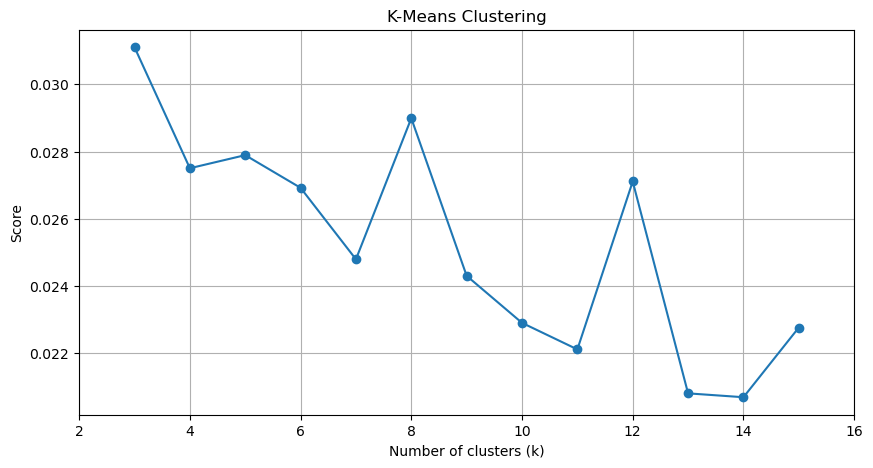

In [31]:
# Assuming cluster_results_km['k'] and cluster_results_km['score'] are your data
plt.figure(figsize=(10, 5))
plt.plot(cluster_results_km['k'], cluster_results_km['score'], marker='o', linestyle='-')
plt.xlim(2, 16)
# Add title and labels
plt.title('K-Means Clustering')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score')

# Add grid
plt.grid(True)

# Show plot
#plt.savefig("number_of_cluster")
plt.show()

In [32]:
num_cluster = 3
km_model = KMeans(n_clusters = num_cluster, init ='k-means++', random_state = 42)
y = km_model.fit_predict(matrix)
combine[f'{num_cluster}_Cluster']=y

/Users/yangzejia/anaconda3/envs/text/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [40]:
combine.drop(['5_Cluster'], inplace=True, axis=1)

### Visualization With k = 5?

Text(0, 0.5, 'Axis 2')

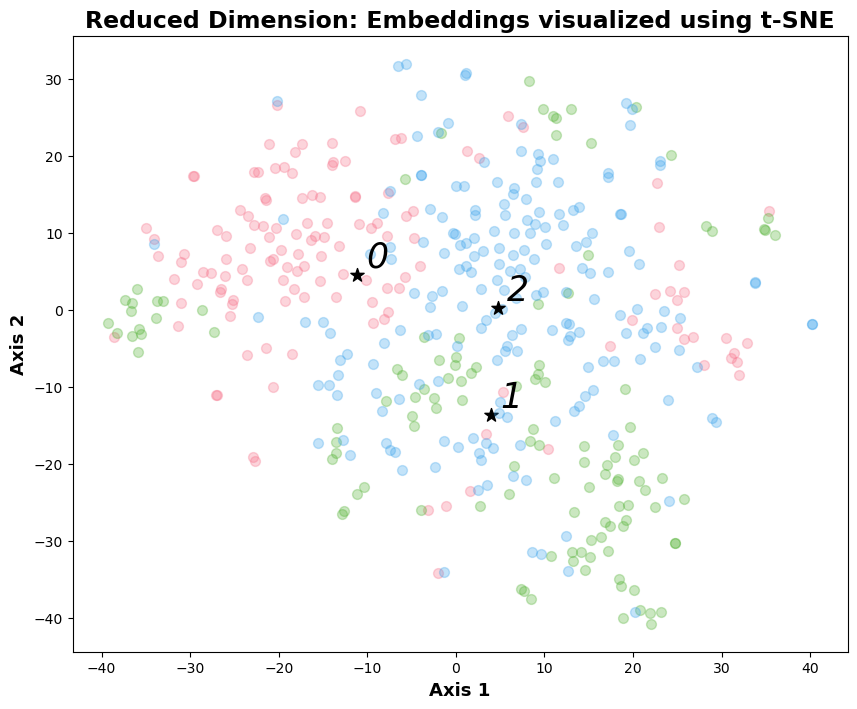

In [42]:
plt.rcParams['figure.figsize'] = (10, 8) 

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
#tsne = TSNE(n_components=2)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x,y in vis_dims2]
y = [y for x,y in vis_dims2]

#palette = sns.color_palette("inferno", num_cluster).as_hex() 
palette = sns.color_palette("husl", num_cluster).as_hex()

for category, color in enumerate(palette):
    xs = np.array(x)[combine[f'{num_cluster}_Cluster']==category]
    ys = np.array(y)[combine[f'{num_cluster}_Cluster']==category]
    plt.scatter(xs, ys, color=color, alpha=0.3, s=50)

    avg_x = xs.mean()
    avg_y = ys.mean()
        
    plt.scatter(avg_x - 1, avg_y - 1, marker='*', color='black', s = 100)
    plt.text(avg_x, avg_y, category, color='black', fontsize=25, fontstyle="italic")
plt.title("Reduced Dimension: Embeddings visualized using t-SNE", size=17, fontweight="bold")
plt.xlabel('Axis 1',size=13, fontweight="bold")
plt.ylabel('Axis 2',size=13, fontweight="bold")
#plt.savefig(f"{num_cluster} with t-SNE")

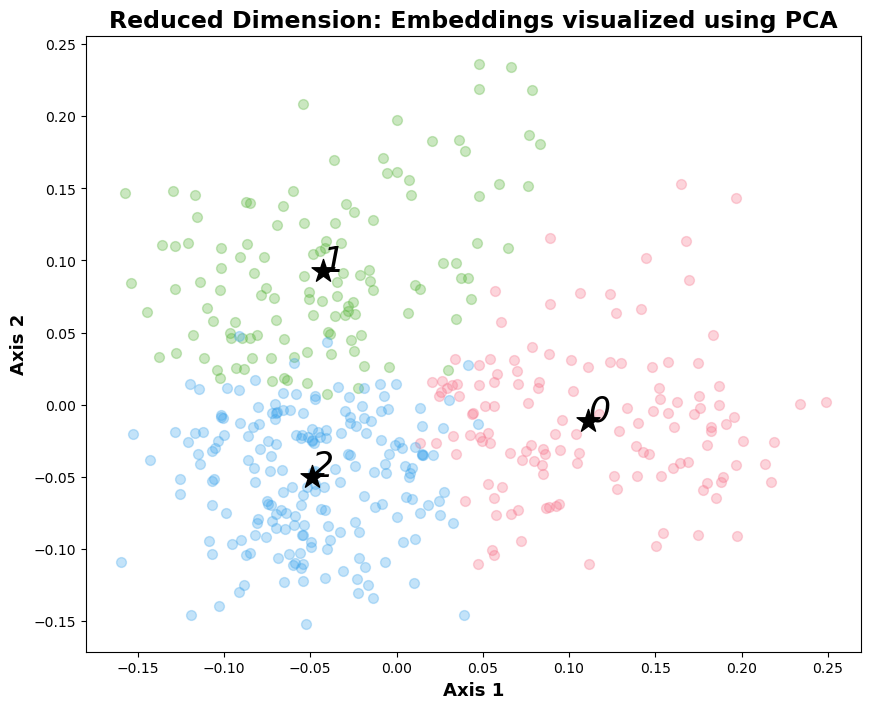

In [43]:
from sklearn.decomposition import PCA

plt.rcParams['figure.figsize'] = (10, 8) 

pca = PCA(n_components=2)
vis_dims2 = pca.fit_transform(matrix)

x = [x for x,y in vis_dims2]
y = [y for x,y in vis_dims2]

#palette = sns.color_palette("inferno", num_cluster).as_hex() 
palette = sns.color_palette("husl", num_cluster).as_hex()

for category, color in enumerate(palette):
    xs = np.array(x)[combine[f'{num_cluster}_Cluster']==category]
    ys = np.array(y)[combine[f'{num_cluster}_Cluster']==category]
    plt.scatter(xs, ys, color=color, alpha=0.3, s=50)

    avg_x = xs.mean()
    avg_y = ys.mean()
    
    plt.scatter(avg_x, avg_y, marker='*', color='black', s=300)
    plt.text(avg_x, avg_y, category, color='black', fontsize=25, fontstyle="italic")
plt.title("Reduced Dimension: Embeddings visualized using PCA", size=17, fontweight="bold")
plt.xlabel('Axis 1',size=13, fontweight="bold")
plt.ylabel('Axis 2',size=13, fontweight="bold")
plt.savefig(f"{num_cluster} with PCA")

In [43]:
combine

,Abstract,v_embedding,3_Cluster
0,Does entrepreneurship education in the first y...,"[-0.007672275882214308, 0.0037649052683264017,...",0
1,Adapting to constructivist approaches to entre...,"[0.015259613282978535, 0.004857480060309172, 0...",2
2,Active entrepreneurship education and the impa...,"[0.01045727077871561, 0.01980374939739704, 0.0...",2
3,Nurturing Entrepreneurial Spirit Through Integ...,"[-0.013149588368833065, 0.018583307042717934, ...",0
4,Developing entrepreneurial behaviours in the C...,"[0.0005821989034302533, -0.005768982227891684,...",2
...,...,...,...
447,The effect of entrepreneur mentoring and its d...,"[-0.005059358663856983, 0.003959860652685165, ...",0
448,What's new in the research on agricultural ent...,"[-0.010267887264490128, 0.0013745925389230251,...",0
449,Towards a more integrated view of entrepreneur...,"[-0.01870742067694664, 0.020452452823519707, 0...",2
450,The formation of youth entrepreneurial intenti...,"[-0.008108139969408512, 0.0258109662681818, 0....",0


In [108]:
combine = combine.drop(['v_embedding', 'Cluster', '3_Cluster'], axis=1)

In [45]:
combine.rename(columns={0: "Abstract"}, inplace=True)
combine

,Abstract,v_embedding,3_Cluster
0,Does entrepreneurship education in the first y...,"[-0.007672275882214308, 0.0037649052683264017,...",0
1,Adapting to constructivist approaches to entre...,"[0.015259613282978535, 0.004857480060309172, 0...",2
2,Active entrepreneurship education and the impa...,"[0.01045727077871561, 0.01980374939739704, 0.0...",2
3,Nurturing Entrepreneurial Spirit Through Integ...,"[-0.013149588368833065, 0.018583307042717934, ...",0
4,Developing entrepreneurial behaviours in the C...,"[0.0005821989034302533, -0.005768982227891684,...",2
...,...,...,...
447,The effect of entrepreneur mentoring and its d...,"[-0.005059358663856983, 0.003959860652685165, ...",0
448,What's new in the research on agricultural ent...,"[-0.010267887264490128, 0.0013745925389230251,...",0
449,Towards a more integrated view of entrepreneur...,"[-0.01870742067694664, 0.020452452823519707, 0...",2
450,The formation of youth entrepreneurial intenti...,"[-0.008108139969408512, 0.0258109662681818, 0....",0


In [46]:
combine[f'{num_cluster}_Cluster'].value_counts()

3_Cluster
2    196
0    134
1    122
Name: count, dtype: int64

In [2]:
raw = pd.read_excel("../data/d.xls")
result = pd.merge(raw, combine, left_index=True, right_index=True)
result.drop(['Abstract_y'], inplace=True, axis=1)
result.sort_values(by=f'{num_cluster}_Cluster', inplace=True)
result.reset_index(inplace=True, drop=True)
result.to_excel(f"d_{num_cluster}_cluster.xlsx")

NameError: name 'pd' is not defined

In [1]:
result['v_embedding']

NameError: name 'result' is not defined